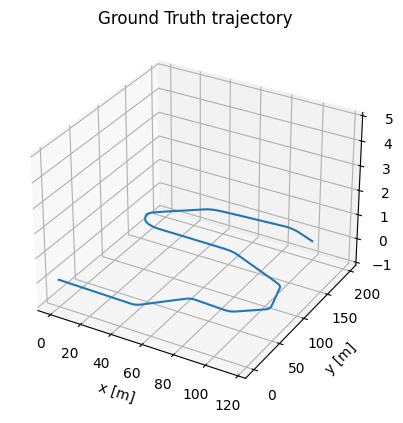

q_est[0] = [ 9.99999999e-01 -2.05063223e-05 -3.39150521e-05  5.31936712e-07]
C_ns_0 = [[ 9.99999998e-01 -1.06248248e-06 -6.78301259e-05]
 [ 1.06526437e-06  9.99999999e-01  4.10126085e-05]
 [ 6.78300822e-05 -4.10126807e-05  9.99999997e-01]]


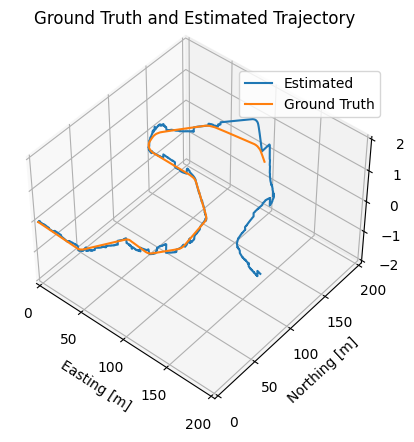

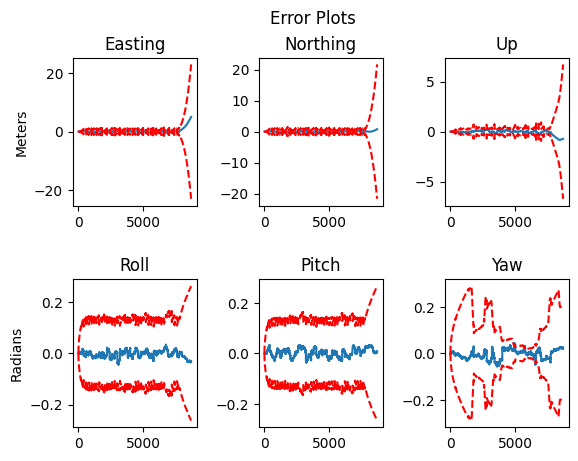

In [1]:

import pickle
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from rotations import angle_normalize, rpy_jacobian_axis_angle, skew_symmetric, Quaternion
from numpy.linalg import inv
import rotations

#### 1. Data ###################################################################################

################################################################################################
# This is where you will load the data from the pickle files. 
################################################################################################
# with open('data/pt1_data.pkl', 'rb') as file:
#     data = pickle.load(file)

with open('data/pt3_data.pkl', 'rb') as file:
    data = pickle.load(file)
################################################################################################
# Each element of the data dictionary is stored as an item from the data dictionary, which we
# will store in local variables, described by the following:
#   gt: Data object containing ground truth. with the following fields:
#     a: Acceleration of the vehicle, in the inertial frame
#     v: Velocity of the vehicle, in the inertial frame
#     p: Position of the vehicle, in the inertial frame
#     alpha: Rotational acceleration of the vehicle, in the inertial frame
#     w: Rotational velocity of the vehicle, in the inertial frame
#     r: Rotational position of the vehicle, in Euler (XYZ) angles in the inertial frame
#     _t: Timestamp in ms.
#   imu_f: StampedData object with the imu specific force data (given in vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   imu_w: StampedData object with the imu rotational velocity (given in the vehicle frame).
#     data: The actual data
#     t: Timestamps in ms.
#   gnss: StampedData object with the GNSS data.
#     data: The actual data
#     t: Timestamps in ms.
#   lidar: StampedData object with the LIDAR data (positions only).
#     data: The actual data
#     t: Timestamps in ms.
################################################################################################
gt = data['gt']
imu_f = data['imu_f']
imu_w = data['imu_w']
gnss = data['gnss']
lidar = data['lidar']

################################################################################################
# Let's plot the ground truth trajectory to see what it looks like.
################################################################################################
gt_fig = plt.figure()
ax = gt_fig.add_subplot(111, projection='3d')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Ground Truth trajectory')
ax.set_zlim(-1, 5)
plt.show()

################################################################################################
# Remember that our LIDAR data is actually just a set of positions estimated from a separate
# scan-matching system, so we can insert it into our solver as another position measurement,
# just as we do for GNSS. However, the LIDAR frame is not the same as the frame shared by the
# IMU and the GNSS. To remedy this, we transform the LIDAR data to the IMU frame using our 
# known extrinsic calibration rotation matrix C_li and translation vector t_i_li.

################################################################################################
# Correct calibration rotation matrix, corresponding to Euler RPY angles (0.05, 0.05, 0.1).
C_li = np.array([
   [ 0.99376, -0.09722,  0.05466],
   [ 0.09971,  0.99401, -0.04475],
   [-0.04998,  0.04992,  0.9975 ]
])


# translation vector
t_i_li = np.array([0.5, 0.1, 0.5])

# Transform from the LIDAR frame to the vehicle (IMU) frame.
lidar.data = (C_li @ lidar.data.T).T + t_i_li

#### 2. Constants ##############################################################################

################################################################################################
# Now that our data is set up, we can start getting things ready for our solver. One of the
# most important aspects of a filter is setting the estimated sensor variances correctly.
# We set the values here.
################################################################################################
var_imu_f = 0.10
var_imu_w = 0.25
var_gnss  = 0.01 # default: 0.01
                  
var_lidar = 1  # default: 1.00
                 

################################################################################################
# We can also set up some constants that won't change for any iteration of our solver.
################################################################################################
g = np.array([0, 0, -9.81])  # gravity
l_jac = np.zeros([9, 6])
l_jac[3:, :] = np.eye(6)  # motion model noise jacobian
h_jac = np.zeros([3, 9])
h_jac[:, :3] = np.eye(3)  # measurement model jacobian

#### 3. Initial Values #########################################################################

################################################################################################
# Let's set up some initial values for our ES-EKF solver.
################################################################################################
p_est = np.zeros([imu_f.data.shape[0], 3])  # position estimates
v_est = np.zeros([imu_f.data.shape[0], 3])  # velocity estimates
q_est = np.zeros([imu_f.data.shape[0], 4])  # orientation estimates as quaternions
p_cov = np.zeros([imu_f.data.shape[0], 9, 9])  # covariance matrices at each timestep

# Set initial values.
p_est[0] = gt.p[0]
v_est[0] = gt.v[0]
q_est[0] = Quaternion( euler = gt.r[0] ).to_numpy()
print("q_est[0] =", q_est[0])
C_ns_0 = Quaternion(*q_est[0]).to_mat()
print("C_ns_0 =", C_ns_0)
p_cov[0] = np.zeros(9)  # covariance of estimate
gnss_i  = 0
lidar_i = 0

#### function: skew operator ##############################################################

################################################################################################
# it computes: skew_operator(a) := { {0, -a_x, a_y}, {a_z, 0, -a_x}, {-a_y, a_x, 0} }
# input: a (3 x 1 sized vector) 
# output: op_mat (3 x 3 sized matrix) 
################################################################################################
def skew_operator(a):
    op_mat = np.zeros([3, 3])
    op_mat[0, 1] = -a[2]
    op_mat[0, 2] = a[1]
    op_mat[1, 0] = a[2]
    op_mat[1, 2] = -a[0]
    op_mat[2, 0] = -a[1]
    op_mat[2, 1] = a[0]

    return op_mat

#### Util function: quaternion product (left) ##################################################
#    TODO: right now, it's incorrect, need to FIX the way creating a quaternion object
#       specifically, how to convert an Euler angle into a quaternion object 
################################################################################################
# it computes: q(theta) "x" q = Omega_q_l @ q
# input: theta 
# output: Omega_q_l 
################################################################################################
def quaternion_left_prod(theta):

    ### normalize the angle first
    theta = angle_normalize(theta)

    ### construct quaternion based on theta info
    theta_norm = np.sqrt(theta[0] ** 2 + theta[1] ** 2 + theta[2] ** 2)
    q_w = np.sin(theta_norm / 2)
    q_v = theta / theta_norm * np.cos(theta_norm / 2)

    Omega = np.zeros([4, 4])
    Omega[0, 1:4]   = -q_v.T
    Omega[1:4, 0]   = q_v
    Omega[1:4, 1:4] = skew_operator(q_v)
    Omega = Omega + np.identity(4) * q_w

    return Omega

#### Util function: quaternion product (right) #################################################
# TODO: right now, it's incorrect, need to FIX the way creating a quaternion object
#       specifically, how to convert an Euler angle into a quaternion object 
################################################################################################
# it computes: q "x" q(theta) = Omega_q_r @ q
# input: theta
# output: Omega_q_r
################################################################################################
def quaternion_right_prod(theta):

    ### normalize the angle first
    theta = angle_normalize(theta)

    ### construct quaternion based on theta info
    theta_norm = np.sqrt(theta[0] ** 2 + theta[1] ** 2 + theta[2] ** 2)
    q_w = np.sin(theta_norm / 2)
    q_v = theta / theta_norm * np.cos(theta_norm / 2)

    Omega = np.zeros([4, 4])
    Omega[0, 1:4]   = -q_v.T
    Omega[1:4, 0]   = q_v
    Omega[1:4, 1:4] = -skew_operator(q_v)
    Omega = Omega + np.identity(4) * q_w

    return Omega

#### Util function: normalize a quaternion  ####################################################

################################################################################################
# it computes: q "x" q(theta) = Omega_q_r @ q
# input: theta
# output: Omega_q_r 
################################################################################################
def normalize_quaternion(q):

    norm = np.sqrt(q[0] ** 2 + q[1] ** 2 + q[2] ** 2 + q[3] ** 2)

    return q / norm

#### 4. Measurement Update #####################################################################

################################################################################################
# Since we'll need a measurement update for both the GNSS and the LIDAR data, let's make
# a function for it.
################################################################################################
def measurement_update(sensor_var, p_cov_check, y_k, p_check, v_check, q_check):

    # construct H_k = [I, 0, 0] (size = 3 x 9)
    H_k = np.zeros([3, 9])
    H_k[0:3, 0:3] = np.identity(3)

    # 3.1 Compute Kalman Gain
    # evaluate size chain: (9 x 9) x (9 x 3) x ( (3 x 9) x (9 x 9) x (9 x 3) + (3 x 3) )
    # K_k should have a size: (9 x 3)
    K_k = p_cov_check @ H_k.T @ inv(H_k @ p_cov_check @ H_k.T + sensor_var)

    # 3.2 Compute error state
    # evaluate size chain: (9 x 3) x ( (3 x 1) - (3 x 1) )
    # delta_x_k should have a size: (9 x 1)
    delta_x_k = K_k @ (y_k - p_check)

    # 3.3 Correct predicted state
    p_hat = p_check + delta_x_k[0:3]
    v_hat = v_check + delta_x_k[3:6]
    ## use of self built function:
    # q_hat = quaternion_left_prod( delta_x_k[6:9] ) @ q_check
    # q_hat = normalize_quaternion(q_hat)
    ## use of pre-built functions:
    q_obj = Quaternion( euler = delta_x_k[6:9] ).quat_mult_left(q_check)
    q_hat = Quaternion(*q_obj).normalize().to_numpy()
    # q_hat = Quaternion(*q_obj).to_numpy() # Note: after test, it tuns out we don't have to normalize the quaternion

    # 3.4 Compute corrected covariance
    # evaluate size chain: ( (9 x 9) - (9 x 3) x (3 x 9) ) x (9 x 9)
    p_cov_hat = ( np.identity(9) - K_k @ H_k ) @ p_cov_check

    return p_hat, v_hat, q_hat, p_cov_hat

#### 5. Main Filter Loop #######################################################################

################################################################################################
# Now that everything is set up, we can start taking in the sensor data and creating estimates
# for our state in a loop.
################################################################################################

# Define some suppotive variables
R_GNSS      =  np.identity(3) * var_gnss    # covariance matrix related to GNSS
R_Lidar     =  np.identity(3) * var_lidar   # covariance matrix related to Lidar
t_imu       =  imu_f.t                      # timestanps of imu
t_gnss      =  gnss.t                       # timestamps of gnss
t_lidar     =  lidar.t                      # timestamps of lidar 
F_k         =  np.identity(9)
L_k         =  np.zeros([9, 6])
L_k[3:9, :] =  np.identity(6)
Q           =  np.identity(6)               # covariance matrix related to noise of IMU
Q[0:3, 0:3] =  Q[0:3, 0:3] * var_imu_f      # covariance matrix related to special force of IMU
Q[3:6, 3:6] =  Q[3:6, 3:6] * var_imu_w      # covariance matrix related to rotational speed of IMU

for k in range(1, imu_f.data.shape[0]):  # start at 1 b/c we have initial prediction from gt

    # some preparations
    delta_t = imu_f.t[k] - imu_f.t[k - 1]
    Q_k = Q * delta_t * delta_t
    C_ns = Quaternion(*q_est[k-1]).to_mat()
    # print("C_ns = ", C_ns)

    # 1. Update state with IMU inputs
    ## 1-1: update position states
    p_est[k] = p_est[k-1] + delta_t * v_est[k-1] + delta_t ** 2 / 2 * (C_ns @ imu_f.data[k-1] + g)
    ## 1-2: update velocity states
    v_est[k] = v_est[k-1] + delta_t * (C_ns @ imu_f.data[k-1] + g)
    ## 1-3: update orientation states
    ## use of self built function:
    # q_est[k] = quaternion_right_prod(imu_w.data[k-1] * delta_t) @ q_est[k-1]
    # q_est[k] = normalize_quaternion(q_est[k])
    ## use of pre-built functions:
    q_tmp = Quaternion( euler = (imu_w.data[k-1] * delta_t) ).quat_mult_right( q_est[k-1] )
    q_est[k] = Quaternion(*q_tmp).normalize().to_numpy()
    # q_est[k] = Quaternion(*q_tmp).to_numpy() # Note: after test, it tuns out we don't have to normalize the quaternion

    # 2. Propagate uncertainty
    ## 2-1: Linearize the motion model and compute Jacobians
    F_k[0:3, 3:6] = np.identity(3) * delta_t
    F_k[3:6, 6:9] = - skew_operator( C_ns @ imu_f.data[k-1] ) * delta_t

    ## 2-2: execute the propagate uncertainty process
    p_cov[k] = F_k @ p_cov[k-1] @ F_k.T + L_k @ Q_k @ L_k.T

    # 3. Check availability of GNSS and LIDAR measurements
    ## at t_imu[k] timestamp GNSS has input
    if np.any( t_gnss == t_imu[k] ):
        # find time index @ iteration k
        # it returns a tuple, (array, description), and the array should only contain 1 element
        t_k = np.where( t_gnss == t_imu[k] )[0][0]
        [ p_est[k], v_est[k], q_est[k], p_cov[k] ] = measurement_update( R_GNSS, p_cov[k], gnss.data[t_k], p_est[k], v_est[k], q_est[k] )

    ## at t_imu[k] timestamp Lidar has input
    if np.any( t_lidar == t_imu[k] ):
        # find time index @ iteration k
        # it returns a tuple, (array, description), and the array should only contain 1 element
        t_k = np.where( t_lidar == t_imu[k] )[0][0]
        [ p_est[k], v_est[k], q_est[k], p_cov[k] ] = measurement_update( R_Lidar, p_cov[k], lidar.data[t_k], p_est[k], v_est[k], q_est[k] )

    # Update states#

#### 6. Results and Analysis ###################################################################

################################################################################################
# Now that we have state estimates for all of our sensor data,  This plot
# will show the ground truth and the estimated trajectories on the same plot. Notice that the
# estimated trajectory continues past the ground truth. This is because we will be evaluating
# your estimated poses from the part of the trajectory where you don't have ground truth!
################################################################################################
est_traj_fig = plt.figure()
ax = est_traj_fig.add_subplot(111, projection='3d')
ax.plot(p_est[:,0], p_est[:,1], p_est[:,2], label='Estimated')
ax.plot(gt.p[:,0], gt.p[:,1], gt.p[:,2], label='Ground Truth')
ax.set_xlabel('Easting [m]')
ax.set_ylabel('Northing [m]')
ax.set_zlabel('Up [m]')
ax.set_title('Ground Truth and Estimated Trajectory')
ax.set_xlim(0, 200)
ax.set_ylim(0, 200)
ax.set_zlim(-2, 2)
ax.set_xticks([0, 50, 100, 150, 200])
ax.set_yticks([0, 50, 100, 150, 200])
ax.set_zticks([-2, -1, 0, 1, 2])
ax.legend(loc=(0.62,0.77))
ax.view_init(elev=45, azim=-50)
plt.show()

################################################################################################
# We can also plot the error for each of the 6 DOF, with estimates for our uncertainty
# included. The error estimates are in blue, and the uncertainty bounds are red and dashed.
# The uncertainty bounds are +/- 3 standard deviations based on our uncertainty (covariance).
################################################################################################
error_fig, ax = plt.subplots(2, 3)
error_fig.suptitle('Error Plots')
num_gt = gt.p.shape[0]
p_est_euler = []
p_cov_euler_std = []

# Convert estimated quaternions to euler angles
for i in range(len(q_est)):
    qc = Quaternion(*q_est[i, :])
    p_est_euler.append(qc.to_euler())

    # First-order approximation of RPY covariance
    J = rpy_jacobian_axis_angle(qc.to_axis_angle())
    p_cov_euler_std.append(np.sqrt(np.diagonal(J @ p_cov[i, 6:, 6:] @ J.T)))

p_est_euler = np.array(p_est_euler)
p_cov_euler_std = np.array(p_cov_euler_std)

# Get uncertainty estimates from P matrix
p_cov_std = np.sqrt(np.diagonal(p_cov[:, :6, :6], axis1=1, axis2=2))

titles = ['Easting', 'Northing', 'Up', 'Roll', 'Pitch', 'Yaw']
for i in range(3):
    ax[0, i].plot(range(num_gt), gt.p[:, i] - p_est[:num_gt, i])
    ax[0, i].plot(range(num_gt),  3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].plot(range(num_gt), -3 * p_cov_std[:num_gt, i], 'r--')
    ax[0, i].set_title(titles[i])
ax[0,0].set_ylabel('Meters')

for i in range(3):
    ax[1, i].plot(range(num_gt), \
        angle_normalize(gt.r[:, i] - p_est_euler[:num_gt, i]))
    ax[1, i].plot(range(num_gt),  3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].plot(range(num_gt), -3 * p_cov_euler_std[:num_gt, i], 'r--')
    ax[1, i].set_title(titles[i+3])
ax[1,0].set_ylabel('Radians')
plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
plt.show()


In [62]:
print(C_ns@f_k)
print(C_ns@f_k + g)
print(delta_t**2*(C_ns@f_k + g))
print(0.5*delta_t**2*(C_ns@f_k +g)[0])
print(p_est)
print(p_est[0])
print(p_est[0][0])
print(v_est)

print(v_est[0][0]*delta_t)
print(p_est[0][0] + delta_t*v_est[0][0] + 0.5*delta_t**2*(C_ns@f_k +g)[0])
print(p_est[0][1] + delta_t*v_est[0][1] + 0.5*delta_t**2*(C_ns@f_k)[1])
print(p_est[0] + delta_t*v_est[0] + 0.5*delta_t**2*(C_ns@f_k))



[-0.01323004  0.05468439  9.77578817]
[-0.01323004  0.05468439 -0.03421183]
[-3.30750960e-07  1.36710974e-06 -8.55295804e-07]
-1.6537548015900926e-07
[[0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.86537127e-07 7.86537127e-07 7.86537127e-07]
 [1.80231346e-05 1.80261410e-05 1.80254866e-05]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00]]
[0. 0. 0.]
0.0
[[-9.72746420e-05  7.79036782e-05  3.62396240e-03]
 [-2.00399543e-04  2.36711173e-04  3.48072862e-03]
 [-3.20312085e-04  4.26678179e-04  3.41474583e-03]
 ...
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00]]
-4.863732101512142e-07
-6.517486903102234e-07
1.0730732584002603e-06
[-6.51748690e-07  1.07307326e-06  1.40317164e-04]
